## Задача:

    Используя метод логистической регрессии из библиотеки PyTorch
    решить задачу классификации рукописных цифр из базы MNIST.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.autograd import Variable

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    Смотрим на данные.

In [3]:
print(train_dataset, '\n\n', test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None 

 Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


		 label:  7


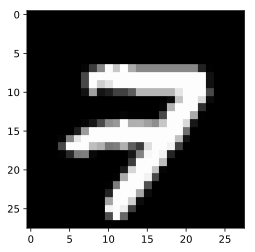

		 (28, 28) px


In [4]:
ix = np.random.randint(60000)
print('\t\t', 'label: ', train_dataset.train_labels[ix].item())
image = train_dataset.train_data[ix]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('\t\t', image.shape, 'px')

In [5]:
total = 0
for i in range(10):
    print ("digit", i, "appear", np.count_nonzero(train_dataset.train_labels == i), "times")

digit 0 appear 5923 times
digit 1 appear 6742 times
digit 2 appear 5958 times
digit 3 appear 6131 times
digit 4 appear 5842 times
digit 5 appear 5421 times
digit 6 appear 5918 times
digit 7 appear 6265 times
digit 8 appear 5851 times
digit 9 appear 5949 times


## О методе логистической регрессии

В основе метода лежит идея о том, что совокупности объектов, относящихся к двум разным классам, будучи представленными точками в многомерном пространстве признаков могут быть разделены гиперплоскостью. Предположим, что мы уже получили веса модели $ \vec{w_{}} $, и она должна давать нам вероятность $ p_{+} $ принадлежности объекта к заданному классу (+), при условии, что тот обладает набором объясняющих признаков $ \vec{x_i} $:

<center> $ \large{p_{+}(\vec{x_i})=\mathbb{P}}\bigl( y=y_i \mid \vec{x_i}, \vec{w_{}} \bigr) $ </center>

Определим отношение вероятностей (odds ratio) $ OR(X) = \frac{\mathbb{P}(X)}{1-\mathbb{P}(X)} $, с множеством значений в $ [0,\infty) $. Поскольку нас интересует отображение значений в $ [0,1] $, будем использовать функцию вида $ f(x) = \frac{1}{1+e^{-x}} $. Получается она, если взять логарифм отношения шансов $ \log(OR_{+}) = \vec{w_{}}^{T}\vec{x_{}} $ и вычислить вероятность принадлежности объекта заданному классу по следующей формуле:

<center> $ \large{p_{+}(\vec{x_i})=\frac{OR_{+}}{1+OR_{+}}} = \frac{\exp(\vec{w_{}}^{T}\vec{x_{}})}{1+\exp(\vec{w_{}}^{T}\vec{x_{}})} = \frac{1}{1+\exp(-\vec{w_{}}^{T}\vec{x_{}})} $ </center>

Вероятность наблюдать распределение $ \vec{y_{}} $ объектов выборки $ X $ по классам (правдоподобие) выглядит так:

<center> $ \large{\mathbb{P}(\vec{y_{}} \mid X, \vec{w_{}}) = \prod_{i=1}^{p}\mathbb{P}(y=y_i \mid \vec{x_{i}}, \vec{w_{}})} $ </center>

Логарифмируя и пользуясь логарифмическими удобствами, получаем:

<center> $ \large{\mathbb{P}(\vec{y_{}} \mid X, \vec{w_{}}) = -\sum_{i=1}^{p}\log(1+\exp(-\vec{y_i} \vec{w_{}}^T \vec{x_i}))} $ </center>

Без минуса будет логистическая функция потерь. Её и будем минимизировать.

Обобщение на мультиномиальную логрегрессию производится следующим образом. Пусть количество категорий классификации равно $ M $. <br> Для классификации по каждому из классов $ k \in M $ запишем $ M - 1 $ логарифмов отношений шансов, где $ m \in M \setminus \{ k \} $ классов:

<center> $ \Large{\log{\frac{\mathbb{P}(y_i = 1)}{\mathbb{P}(y_i = M)}} = \vec{w_{1}}^T\vec{x_i}} $ </center>
<center> $ \Large{\log{\frac{\mathbb{P}(y_i = 2)}{\mathbb{P}(y_i = M)}} = \vec{w_{2}}^T\vec{x_i}} $ </center>
<center> $ \dots $ </center>
<center> $ \Large{\log{\frac{\mathbb{P}(y_i = M-1)}{\mathbb{P}(y_i = M)}} = \vec{w_{}}_{M-1}^T\vec{x_i}} $ </center>

Соответственно,

<center> $ \Large{\mathbb{P}(y_i=1) = \mathbb{P}(y_i=M) \exp{\vec{w_1}^T \vec{x_i}} }$ </center>
<center> $ \Large{\mathbb{P}(y_i=2) = \mathbb{P}(y_i=M) \exp{\vec{w_2}^T \vec{x_i}} }$ </center>
<center> $ \dots $ </center>
<center> $ \Large{\mathbb{P}(y_i=M-1) = \mathbb{P}(y_i=M) \exp{\vec{w_{}}_{M-1}^T \vec{x_i}} }$ </center>

<br>

<center> $ \Large{\mathbb{P}(y_i=M) = 1 - \sum_{m=1}^{M-1}{\mathbb{P}(y_i = m}) = } $ </center>

<br>

<center> $ \Large{1 - \sum_{m=1}^{M-1}{\mathbb{P}(y_i = M) \exp{\vec{w_m}^T \vec{x_i}}}} \Rightarrow  $ </center>

<br>

<center> $ \Large{\mathbb{P}(y_i = M}) = \frac{1}{1 + \sum\limits_{m =1}^{M-1} \exp{\vec{w_{m}}^T\vec{x_i}}} $ </center>

Логарифмируя, опять получим функцию потерь со знаком минус, на этот раз уже для мультиномиальной регресии.

***

In [6]:
num_inputs = 28*28
num_outputs = 10
num_examples = 60000

In [7]:
def forward(X):
    return torch.mm(X, W).add_(b)

In [8]:
def softmax(X):
    linear = forward(X)
    numerator = torch.exp(linear.sub(linear.max()))
    denominator = numerator.sum()
    return numerator.div(denominator)

In [9]:
def cross_entropy(y, z):
    return -torch.mul(y, torch.log(z)).sum(1).mean()

In [10]:
def one_hot_embedding(labels, num_classes=10):
    return torch.eye(num_classes)[labels] 

In [11]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})

W = Variable(torch.DoubleTensor(size=(num_inputs, num_outputs)).uniform_(), requires_grad=True)
b = Variable(torch.DoubleTensor(num_outputs).uniform_(), requires_grad=True)

pause = '\n'
epochs = 10
learning_rate = 1e-03

for epoch in range(epochs):
    for index, (data, labels) in enumerate(train_loader):
        X = data.contiguous().view(batch_size, num_inputs).double()
        y = one_hot_embedding(labels).double()
        z = softmax(X)
#         print('mean z\n', z.mean(0).data.cpu().numpy())
        l = cross_entropy(y, z)
#         print('cross-entropy\n', l.data.cpu().numpy())
        l.backward()
#         print('weights\n', W.data.cpu().numpy())
        W.data = W.data - learning_rate * W.grad.data
#         print('dl/dw\n', W.grad.data.cpu().numpy())
        W.grad.data.zero_()
#         print('bias\n', b.data.cpu().numpy())
        b.data = b.data - learning_rate * b.grad.data
#         print('dl/db\n', b.grad.data.cpu().numpy())
        b.grad.data.zero_()
#         input(pause)
    print('epoch: ', epoch, ' loss: ', l)
#     break

epoch:  0  loss:  tensor(42.8765, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  1  loss:  tensor(38.0555, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  2  loss:  tensor(60.5601, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  3  loss:  tensor(38.9270, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  4  loss:  tensor(40.4938, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  5  loss:  tensor(57.8446, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  6  loss:  tensor(42.0848, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  7  loss:  tensor(40.0470, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  8  loss:  tensor(26.9864, dtype=torch.float64, grad_fn=<NegBackward>)
epoch:  9  loss:  tensor(50.5941, dtype=torch.float64, grad_fn=<NegBackward>)


In [14]:
preds = []
for index, (data, labels) in enumerate(test_loader):
        X = data.contiguous().view(batch_size, num_inputs).double()
        y = one_hot_embedding(labels).double()
        z = softmax(X)
        l = cross_entropy(y, z)
        preds.append(l)
print('mean loss by test batches: ', (sum(preds)/len(preds)).detach().numpy())

mean loss by test batches:  28.876529650740554


		 label:  8


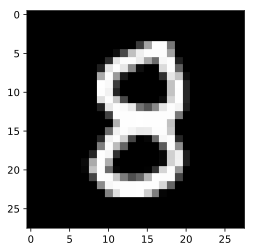

		 (28, 28) px


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
ix = np.random.randint(60000)
print('\t\t', 'label: ', train_dataset.train_labels[ix].item())
image = train_dataset.train_data[ix]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('\t\t', image.shape, 'px')

ixs = train_loader.dataset.train_data[ix].view(1, num_inputs).double()
s = (softmax(ixs)*10).int().float()/10
pd.DataFrame(s.numpy())